In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('datasets/train/train_emoticon.csv')
data_valid = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Assuming the dataset has two columns 'input_emoticons' and 'label'
X = data['input_emoticon']  # Emoji sequences
y = data['label']  # Labels (0 or 1)

X_valid = data_valid['input_emoticon']  # Emoji sequences
y_valid = data_valid['label']  # Labels (0 or 1)

# Step 1: Use TfidfVectorizer to convert the emojis into a TF-IDF representation
# This treats the emojis as unique "words" or tokens
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))  # Using n-grams for better contextual info

# Fit the vectorizer on the training data and transform both train and validation data
X_train_tfidf = tfidf_vectorizer.fit_transform(X)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

# Step 2: Train RandomForest Classifier model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y)

# Step 3: Make predictions on the validation set
y_pred = rf_model.predict(X_valid_tfidf)

# Step 4: Calculate accuracy
accuracy_rf = accuracy_score(y_valid, y_pred)
print(f"RandomForest Accuracy on validation set: {accuracy_rf * 100:.2f}%")

# Step 5: Hyperparameter tuning using GridSearchCV (optional)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y)

# Get the best model and parameters
best_rf_model = grid_search.best_estimator_

# Step 6: Evaluate best model on validation set
y_pred_best = best_rf_model.predict(X_valid_tfidf)
accuracy_best_rf = accuracy_score(y_valid, y_pred_best)
print("Best Parameters found by GridSearchCV:", grid_search.best_params_)
print(f"RandomForest (Best Model) Accuracy on validation set: {accuracy_best_rf * 100:.2f}%")


RandomForest Accuracy on validation set: 57.87%
Best Parameters found by GridSearchCV: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
RandomForest (Best Model) Accuracy on validation set: 57.46%


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('datasets/train/train_emoticon.csv')
data_valid = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Assuming the dataset has two columns 'input_emoticons' and 'label'
X = data['input_emoticon']  # Emoji sequences
y = data['label']  # Labels (0 or 1)

X_valid = data_valid['input_emoticon']  # Emoji sequences
y_valid = data_valid['label']  # Labels (0 or 1)

# Function to convert emojis to their Unicode code points
def emojis_to_unicode(emojis):
    return [ord(emoji) for emoji in emojis]

# Convert each input_emoticons entry to a list of Unicode values
X_unicode = np.array([emojis_to_unicode(list(emojis)) for emojis in X])
X_unicode_valid = np.array([emojis_to_unicode(list(emojis)) for emojis in X_valid])

# Pad or truncate the Unicode representations to a fixed length (13, since each entry has 13 emojis)
X_unicode_fixed = np.array([np.pad(seq, (0, max(0, 13 - len(seq))), 'constant')[:13] for seq in X_unicode])
X_unicode_fixed_valid = np.array([np.pad(seq, (0, max(0, 13 - len(seq))), 'constant')[:13] for seq in X_unicode_valid])

# Step 2: Split the dataset into training and validation sets
X_train=X_unicode_fixed
y_train=y
X_valid=X_unicode_fixed_valid
#y_valid=y_valid

# Step 3: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Step 4: Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
    'gamma': ['scale', 'auto'],      # Kernel coefficient for 'rbf', 'poly'
    'degree': [2, 3, 4]              # Degree of the polynomial kernel function (only applies to 'poly')
}

# Instantiate SVM model
svm_model = SVC()

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and model
best_svm_model = grid_search.best_estimator_

# Step 5: Make predictions on the validation set
y_pred = best_svm_model.predict(X_valid_scaled)

# Step 6: Calculate and print accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Best Parameters found by GridSearchCV:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("SVM Accuracy on validation set:", accuracy)

Best Parameters found by GridSearchCV: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best Cross-Validation Accuracy: 0.5848870056497175
SVM Accuracy on validation set: 0.5869120654396728


In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the datasets
train = pd.read_csv('datasets/train/train_emoticon.csv')
valid = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Tokenize the input data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train['input_emoticon'])

X_train = tokenizer.texts_to_sequences(train['input_emoticon'])
X_val = tokenizer.texts_to_sequences(valid['input_emoticon'])

# Padding the sequences
X_train = pad_sequences(X_train, maxlen=13, padding='post')
X_val = pad_sequences(X_val, maxlen=13, padding='post')

# Define the labels
y_train = train['label']
y_val = valid['label']

# Define the Keras model
input_shape = (13,)
embedding_dim = 32
vocab_size = len(tokenizer.word_index) + 1

# Input layer
input_layer = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

# Flatten the embeddings
x = Flatten()(embedding_layer)

# Add a Dense layer for classification
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model for 20 epochs only
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_class = (y_pred > 0.5).astype("int32")
print('Neural Network Validation Accuracy:', accuracy_score(y_val, y_pred_class))

# No. of Parameters
vocab_size = len(tokenizer.word_index) + 1
input_dim = 13 * embedding_dim
output_dim = 1

num_trainable_params_embedding = vocab_size * embedding_dim
num_trainable_params_dense = input_dim * output_dim + output_dim
total_num_trainable_params = num_trainable_params_embedding + num_trainable_params_dense

print(f"Total number of trainable parameters: {total_num_trainable_params}")

# Feature Extraction using the embedding layer
embedding_model = Model(inputs=model.input, outputs=model.layers[1].output)

# Get the embeddings for the train and validation data
X_train_embeddings = embedding_model.predict(X_train)
X_val_embeddings = embedding_model.predict(X_val)

# Flatten the embeddings to use them as features for traditional models
X_train_embeddings_flat = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1)
X_val_embeddings_flat = X_val_embeddings.reshape(X_val_embeddings.shape[0], -1)

# Standardize the features (important for many ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embeddings_flat)
X_val_scaled = scaler.transform(X_val_embeddings_flat)

# Initialize models
log_reg = LogisticRegression(max_iter=500)
decision_tree = DecisionTreeClassifier()
svm = SVC()
knn = KNeighborsClassifier()

# Train and evaluate Logistic Regression
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled)
log_reg_acc = accuracy_score(y_val, y_pred_log_reg)
print(f"Logistic Regression Validation Accuracy: {log_reg_acc * 100:.2f}%")

# Train and evaluate Decision Tree
decision_tree.fit(X_train_scaled, y_train)
y_pred_decision_tree = decision_tree.predict(X_val_scaled)
decision_tree_acc = accuracy_score(y_val, y_pred_decision_tree)
print(f"Decision Tree Validation Accuracy: {decision_tree_acc * 100:.2f}%")

# Train and evaluate SVM
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_val_scaled)
svm_acc = accuracy_score(y_val, y_pred_svm)
print(f"SVM Validation Accuracy: {svm_acc * 100:.2f}%")

# Train and evaluate KNN
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_val_scaled)
knn_acc = accuracy_score(y_val, y_pred_knn)
print(f"KNN Validation Accuracy: {knn_acc * 100:.2f}%")


Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5854 - loss: 0.6861 - val_accuracy: 0.8344 - val_loss: 0.6058
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8920 - loss: 0.5304 - val_accuracy: 0.9407 - val_loss: 0.3181
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9535 - loss: 0.2748 - val_accuracy: 0.9632 - val_loss: 0.2046
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9766 - loss: 0.1803 - val_accuracy: 0.9673 - val_loss: 0.1569
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.9799 - loss: 0.1436 - val_accuracy: 0.9755 - val_loss: 0.1307
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9870 - loss: 0.1192 - val_accuracy: 0.9796 - val_loss: 0.1144
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9888 - loss: 0.0987 - val_accuracy: 0.9796 - val_loss: 0.1022
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9896 - loss: 0.0881 - val_accuracy

In [27]:
# Number of features from the embedding layer
n_features = X_train_embeddings_flat.shape[1]  # Should be 416, as 13 * 32 = 416

# Number of parameters for Logistic Regression and SVM
n_params_log_reg = n_features + 1  # +1 for the bias term
n_params_svm = n_features + 1      # +1 for the bias term

# Output the number of parameters for Logistic Regression and SVM
print(f"Number of parameters for Logistic Regression: {n_params_log_reg}")
print(f"Number of parameters for SVM: {n_params_svm}")

# KNN doesn't have parameters in the traditional sense, as it uses the entire training dataset for predictions
print("KNN is a non-parametric model (no trainable parameters).")

# Decision Tree has dynamically determined parameters, depending on the depth and number of nodes.
print("The number of parameters for a Decision Tree varies depending on the tree structure (depth and nodes).")


Number of parameters for Logistic Regression: 417
Number of parameters for SVM: 417
KNN is a non-parametric model (no trainable parameters).
The number of parameters for a Decision Tree varies depending on the tree structure (depth and nodes).


# Best Model

In [29]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input
from sklearn.metrics import accuracy_score

# Load the datasets
train = pd.read_csv('datasets/train/train_emoticon.csv')
valid = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Tokenize the input data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train['input_emoticon'])

X_train = tokenizer.texts_to_sequences(train['input_emoticon'])
X_val = tokenizer.texts_to_sequences(valid['input_emoticon'])

# Padding the sequences
X_train = pad_sequences(X_train, maxlen=13, padding='post')
X_val = pad_sequences(X_val, maxlen=13, padding='post')

# Define the labels
y_train = train['label']
y_val = valid['label']

# Define the Keras model
input_shape = (13,)
embedding_dim = 32
vocab_size = len(tokenizer.word_index) + 1

# Input layer
input_layer = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

# Flatten the embeddings
x = Flatten()(embedding_layer)

# Add a Dense layer for classification
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model 
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_class = (y_pred > 0.5).astype("int32")
print('Validation Accuracy:', accuracy_score(y_val, y_pred_class))

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Number of Parameters
vocab_size = len(tokenizer.word_index) + 1
input_dim = 13 * embedding_dim
output_dim = 1

num_trainable_params_embedding = vocab_size * embedding_dim
num_trainable_params_dense = input_dim * output_dim + output_dim
total_num_trainable_params = num_trainable_params_embedding + num_trainable_params_dense

print(f"Total number of trainable parameters: {total_num_trainable_params}")


Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5622 - loss: 0.6870 - val_accuracy: 0.9018 - val_loss: 0.6227
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9106 - loss: 0.5521 - val_accuracy: 0.9366 - val_loss: 0.3365
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.2888 - val_accuracy: 0.9632 - val_loss: 0.2096
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9742 - loss: 0.1857 - val_accuracy: 0.9632 - val_loss: 0.1597
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9810 - loss: 0.1418 - val_accuracy: 0.9714 - val_loss: 0.1321
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.1192 - val_accuracy: 0.9673 - val_loss: 0.1181
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9876 - loss: 0.1022 - val_accuracy: 0.9775 - val_loss: 0.1036
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9883 - loss: 0.0882 - val_accuracy: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy with 20% of data: 92.64%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy with 40% of data: 95.50%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy with 60% of data: 97.14%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy with 80% of data: 97.75%
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation Accuracy with 100% of data: 98.16%


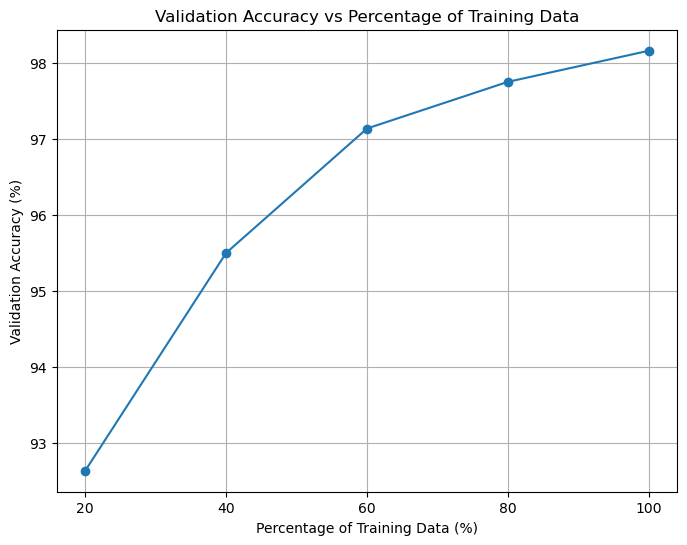

In [33]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the datasets
train = pd.read_csv('datasets/train/train_emoticon.csv')
valid = pd.read_csv('datasets/valid/valid_emoticon.csv')

# Tokenize the input data
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train['input_emoticon'])

X_train = tokenizer.texts_to_sequences(train['input_emoticon'])
X_val = tokenizer.texts_to_sequences(valid['input_emoticon'])

# Padding the sequences
X_train = pad_sequences(X_train, maxlen=13, padding='post')
X_val = pad_sequences(X_val, maxlen=13, padding='post')

# Define the labels
y_train = train['label']
y_val = valid['label']

# Define the Keras model function
def create_model():
    input_shape = (13,)
    embedding_dim = 32
    vocab_size = len(tokenizer.word_index) + 1

    # Input layer
    input_layer = Input(shape=input_shape)

    # Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    # Flatten the embeddings
    x = Flatten()(embedding_layer)

    # Add a Dense layer for classification
    output_layer = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# List of percentages to train on
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
validation_accuracies = []

# Train the model on different percentages of data
for percentage in percentages:
    # Calculate the number of samples to use
    num_samples = int(len(X_train) * percentage)
    
    # Use a subset of the training data
    X_train_subset = X_train[:num_samples]
    y_train_subset = y_train[:num_samples]
    
    # Create and train the model
    model = create_model()
    model.fit(X_train_subset, y_train_subset, epochs=20, validation_data=(X_val, y_val), batch_size=32, verbose=0)
    
    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    y_pred_class = (y_pred > 0.5).astype("int32")
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_val, y_pred_class)
    validation_accuracies.append(accuracy)
    print(f"Validation Accuracy with {int(percentage * 100)}% of data: {accuracy * 100:.2f}%")

# Plot the validation accuracy
plt.figure(figsize=(8, 6))
plt.plot([int(p * 100) for p in percentages], [acc * 100 for acc in validation_accuracies], marker='o')
plt.title('Validation Accuracy vs Percentage of Training Data')
plt.xlabel('Percentage of Training Data (%)')
plt.ylabel('Validation Accuracy (%)')
plt.xticks([20, 40, 60, 80, 100])
plt.grid()
plt.show()
